<a href="https://colab.research.google.com/github/NoVegetable/Denoising-Autoencoder/blob/main/Denoising_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Build Folders for Training and Testing Data**

In [ ]:
!mkdir train
!mkdir test

# **Import Packages**

In [ ]:
import numpy as np
import random
import pandas as pd
import csv
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import PIL.Image as Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# **Set Random Seeds**

In [ ]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# **Set Hyperparamters**

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
batch_size = 64
max_iter = 10000
noise_factor = 10
noise_mean = 0
noise_var = 1

# **Data Augmentation**

In [ ]:
train_transformer = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor()
])

test_transformer = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# **Construct Dataset and DataLoader**

In [ ]:
def _add_noise(img, factor, mean=0, var=1):
    return img + factor/255*torch.normal(mean, var, img.shape)

In [ ]:
train_set = CIFAR10(root='train', train=True, transform=train_transformer, download=(len(os.listdir('train')) == 0))
val_set = CIFAR10(root='train', train=True, transform=test_transformer, download=(len(os.listdir('train')) == 0))
test_set = CIFAR10(root='test', train=False, transform=test_transformer, download=(len(os.listdir('test')) == 0))

train_data, val_data, train_targets, val_targets = train_test_split(train_set.data, np.array(train_set.targets), test_size=0.10)

train_set.data = train_data
train_set.targets = train_targets.tolist()
val_set.data = val_data
val_set.targets = val_targets.tolist()

train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train data: {len(train_set)} samples")
print(f"Valid data: {len(val_set)} samples")
print(f"Test data: {len(test_set)} samples")

Train data: 45000 samples
Valid data: 5000 samples
Test data: 10000 samples


# **Define Denoising Autoencoder**

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(EncoderBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU(True)
        self.maxpool = nn.MaxPool2d((2, 2), return_indices=True)

    def forward(self, x):
        y = self.lrelu(self.bn(self.conv(x)))
        y, indices = self.maxpool(y)
        return y, indices

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(DecoderBlock, self).__init__()
        self.transpose_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(in_channels)
        self.lrelu = nn.LeakyReLU(True)
        self.maxunpool = nn.MaxUnpool2d((2, 2))

    def forward(self, x, indices):
        y = self.maxunpool(x, indices)
        y = self.transpose_conv(self.lrelu(self.bn(y)))
        return y

class SimpleDAE(nn.Module):
    def __init__(self, input_size):
        super(SimpleDAE, self).__init__()
        self.pool_indices = []

        self.encoder_block1 = EncoderBlock(3, 128, 4, 2, 1)
        self.encoder_block2 = EncoderBlock(128, 256, 4, 2, 1)

        self.bottleneck = nn.Sequential(
            nn.Linear(256*2*2, 128),
            nn.Linear(128, 256*2*2)
        )

        self.decoder_block1 = DecoderBlock(256, 128, 4, 2, 1)
        self.decoder_block2 = DecoderBlock(128, 3, 4, 2, 1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        self.pool_indices = []

        y, indices = self.encoder_block1(x)
        self.pool_indices.append(indices)
        y, indices = self.encoder_block2(y)
        self.pool_indices.append(indices)

        enc_out_shape = y.shape

        y = y.flatten(start_dim=1)
        y = self.bottleneck(y)

        y = torch.reshape(y, enc_out_shape)

        y = self.decoder_block1(y, self.pool_indices[-1])
        y = self.decoder_block2(y, self.pool_indices[-2])
        y = self.sigmoid(y) # Map the outputs into the interval [0,1] ([0,1] x 255 = [0,255])
        return y

# **Training and Scoring**

In [ ]:
def Train(train_loader, val_loader, model, objective, optimizer, max_iter=1000, save_file='model.pt', lr_scheduler=None):
    best_loss = np.inf
    iter = 0
    train_loss_record = []
    while iter < max_iter:
        for i, (img, targets) in enumerate(train_loader):
            model.train()

            optimizer.zero_grad()
            n_img = _add_noise(img, noise_factor, noise_mean, noise_var)
            img, n_img = img.to(device), n_img.to(device)
            r_img = model(n_img)
            loss = objective(r_img, img)

            loss.backward()
            optimizer.step()
            iter += 1

            train_loss_record.append(loss.item())

            if lr_scheduler is not None:
                lr_scheduler.step()

            if iter % 100 == 0:
                print(f"[{iter}/{max_iter}] Train Loss: {np.mean(train_loss_record[-100]):.5f}")
                val_loss = Score(val_loader, model, objective)
                if val_loss < best_loss:
                    best_loss = val_loss
                    torch.save(model.state_dict(), save_file)
                    print(f"[{iter}/{max_iter}] Val Loss: {val_loss:.5f}, Best Loss: {best_loss:.5f}")

            if iter == max_iter:
                break

    model.load_state_dict(torch.load(save_file))
    return model

def Score(eval_loader, model, objective):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for i, (img, targets) in enumerate(eval_loader):
            n_img = _add_noise(img, noise_factor, noise_mean, noise_var)
            img, n_img = img.to(device), n_img.to(device)
            r_img = model(n_img)
            loss = objective(r_img, img)
            total_loss += loss*img.shape[0]
        total_loss /= len(eval_loader.dataset)
    return total_loss

In [ ]:
model = SimpleDAE(64).to(device)
objective = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.3, momentum=0.9, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_iter)
model = Train(train_loader, val_loader, model, objective, optimizer, max_iter, 'model.pt', lr_scheduler)
score = Score(val_loader, model, objective)
print(f"The Validate loss is {score:.5f}")

[100/10000] Train Loss: 0.15583
[100/10000] Val Loss: 0.02908, Best Loss: 0.02908
[200/10000] Train Loss: 0.02908
[200/10000] Val Loss: 0.01803, Best Loss: 0.01803
[300/10000] Train Loss: 0.01819
[300/10000] Val Loss: 0.01405, Best Loss: 0.01405
[400/10000] Train Loss: 0.01348
[400/10000] Val Loss: 0.01126, Best Loss: 0.01126
[500/10000] Train Loss: 0.01199
[500/10000] Val Loss: 0.01063, Best Loss: 0.01063
[600/10000] Train Loss: 0.01182
[600/10000] Val Loss: 0.00968, Best Loss: 0.00968
[700/10000] Train Loss: 0.01030
[700/10000] Val Loss: 0.00877, Best Loss: 0.00877
[800/10000] Train Loss: 0.01029
[800/10000] Val Loss: 0.00829, Best Loss: 0.00829
[900/10000] Train Loss: 0.00864
[900/10000] Val Loss: 0.00792, Best Loss: 0.00792
[1000/10000] Train Loss: 0.00837
[1000/10000] Val Loss: 0.00731, Best Loss: 0.00731
[1100/10000] Train Loss: 0.00758
[1100/10000] Val Loss: 0.00689, Best Loss: 0.00689
[1200/10000] Train Loss: 0.00746
[1300/10000] Train Loss: 0.00754
[1300/10000] Val Loss: 0.006

# **Display some Examples**

In [ ]:
def tensor_to_image(img):
    return Image.fromarray(np.uint8(img.permute(1, 2, 0).numpy()*255), mode='RGB')

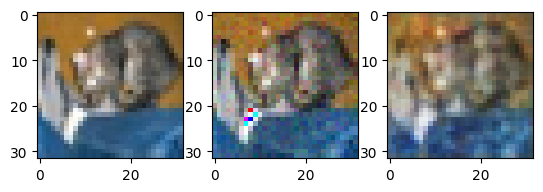

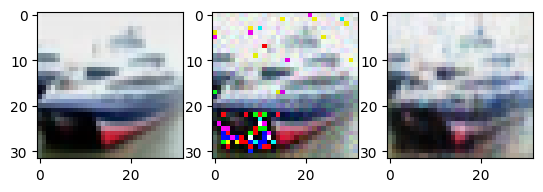

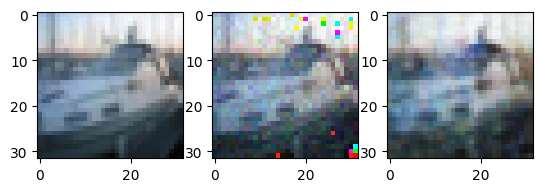

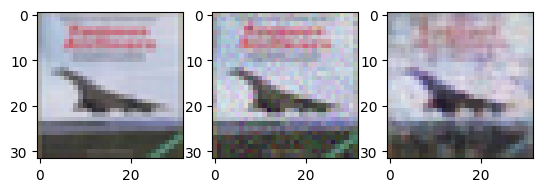

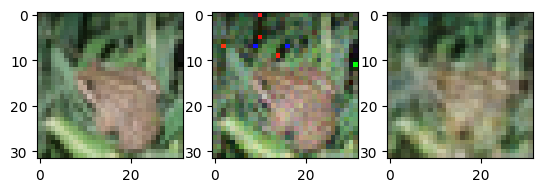

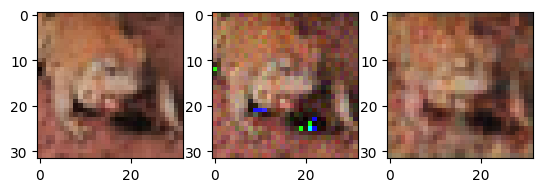

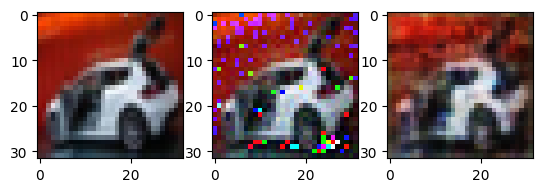

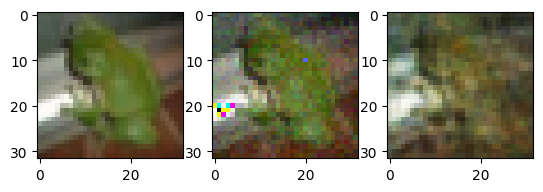

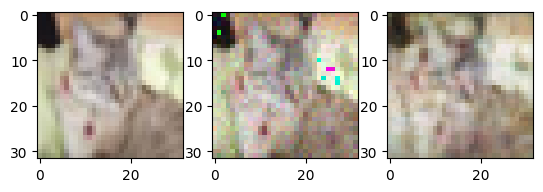

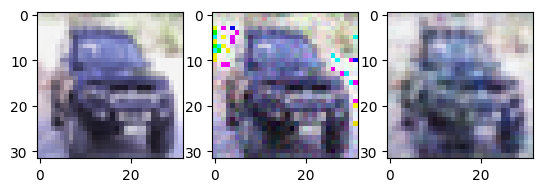

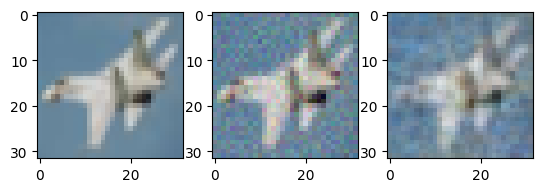

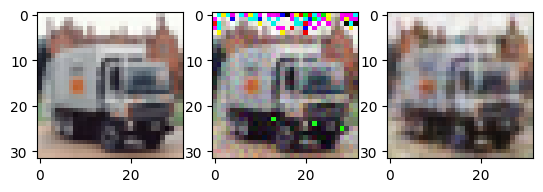

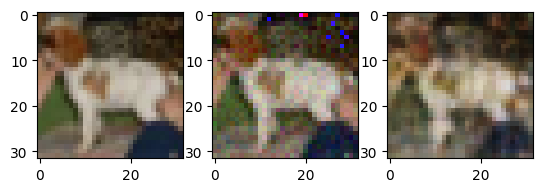

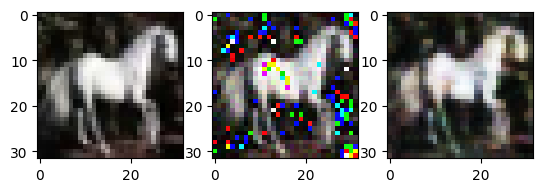

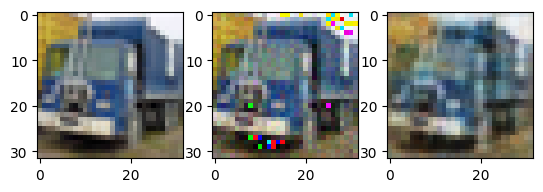

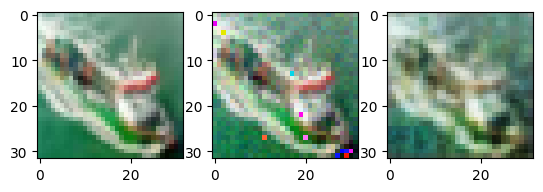

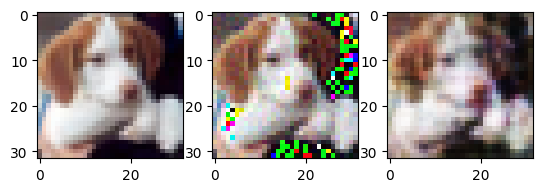

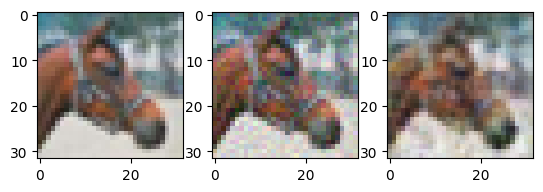

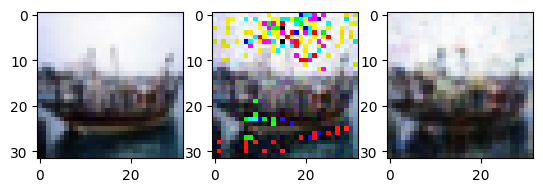

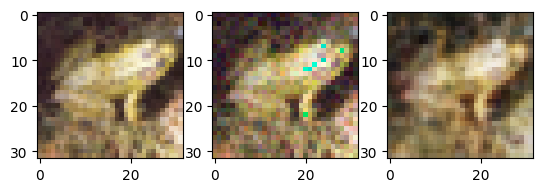

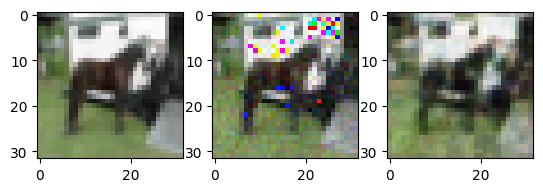

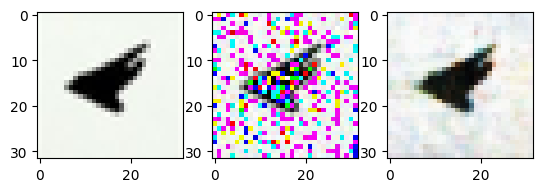

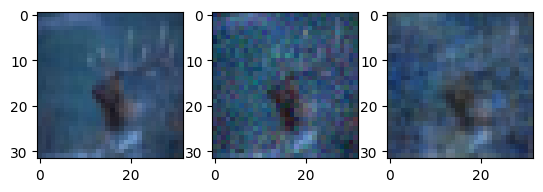

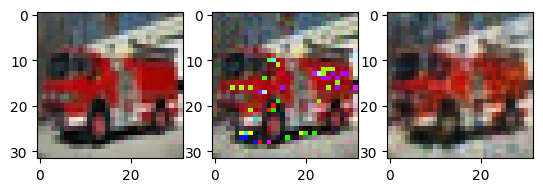

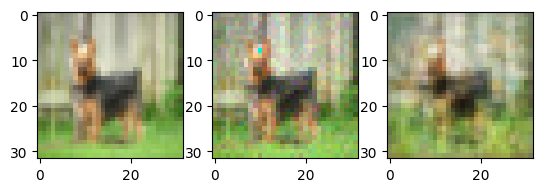

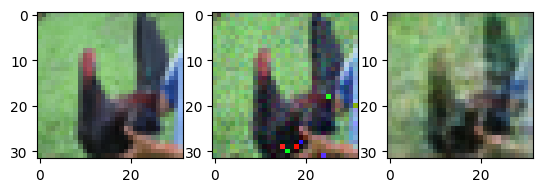

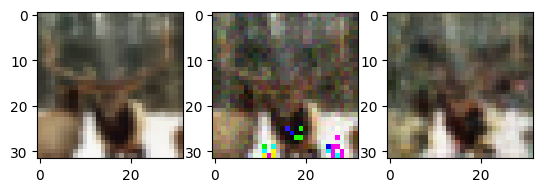

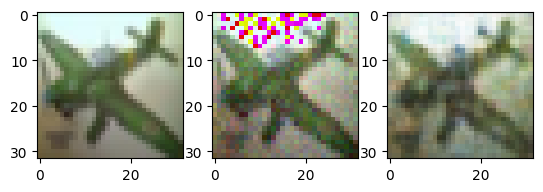

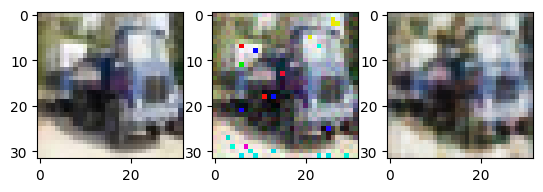

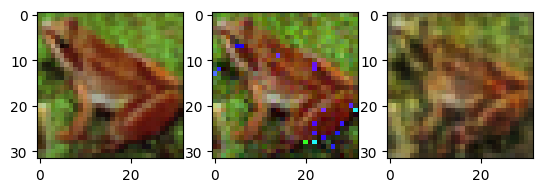

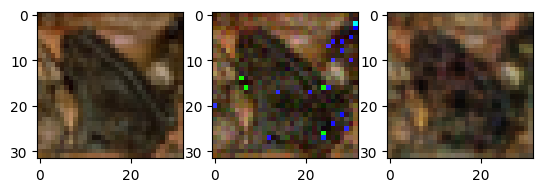

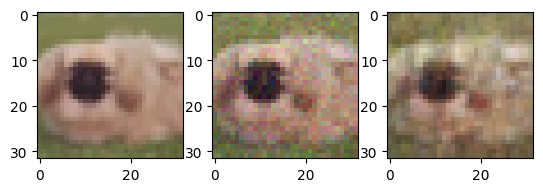

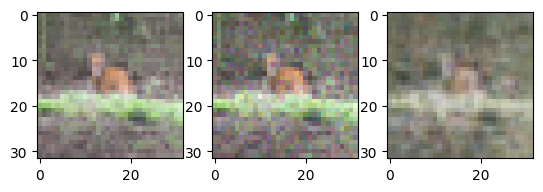

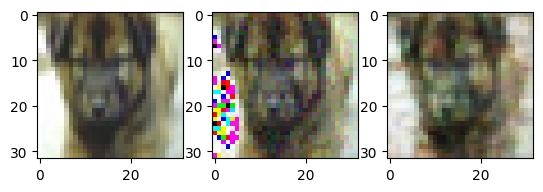

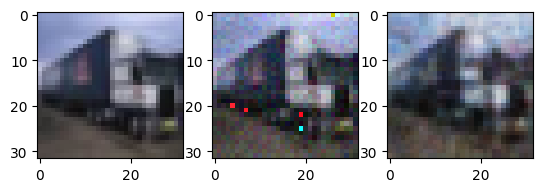

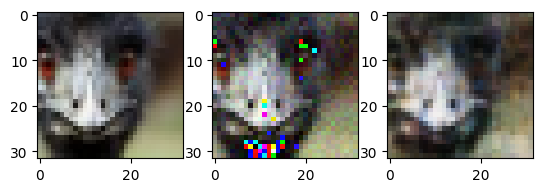

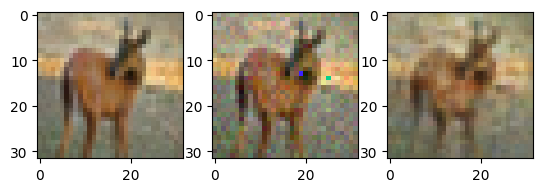

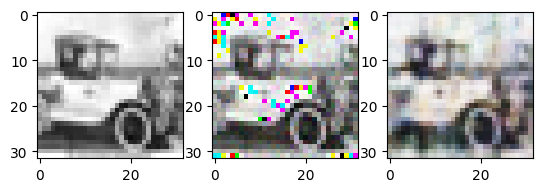

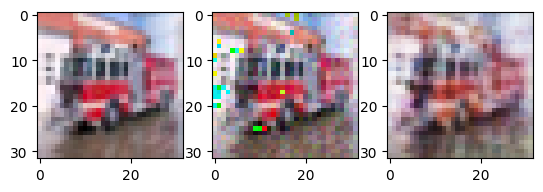

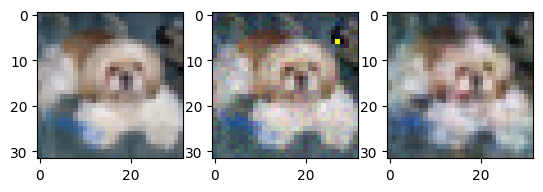

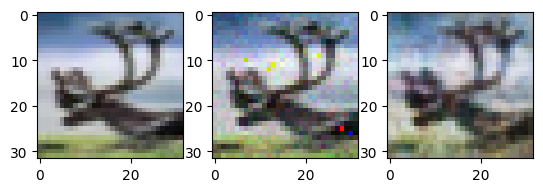

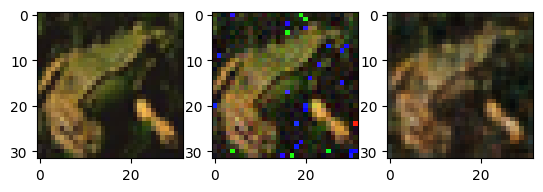

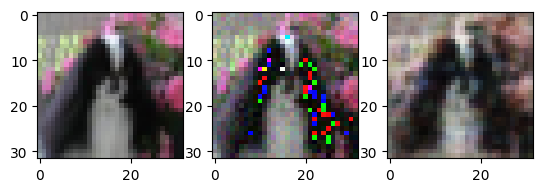

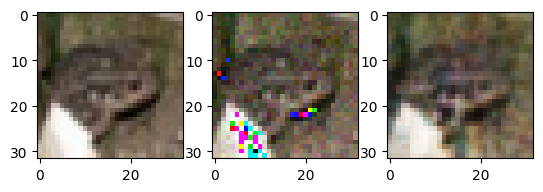

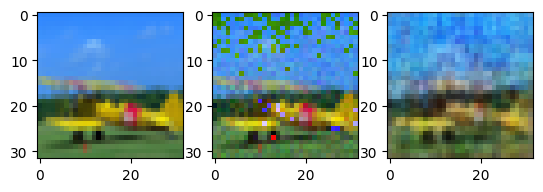

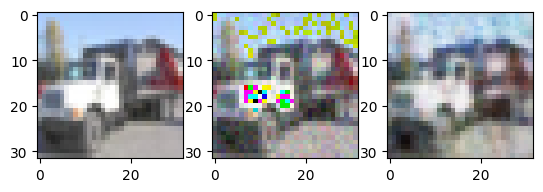

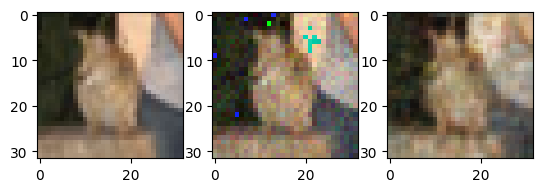

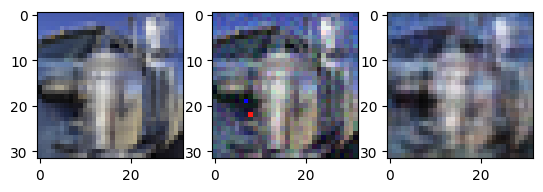

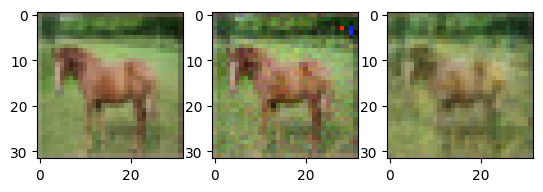

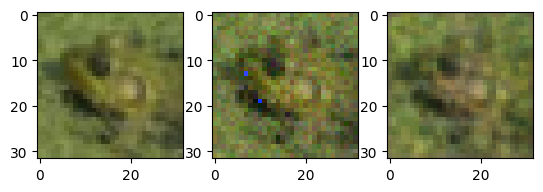

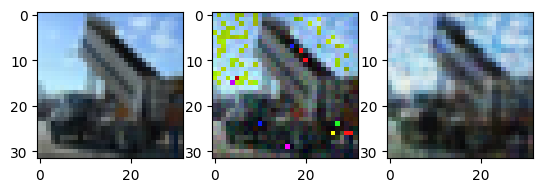

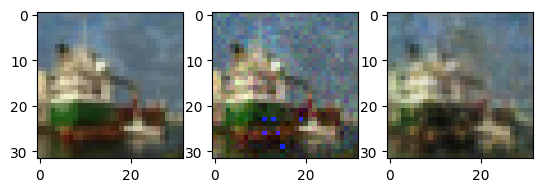

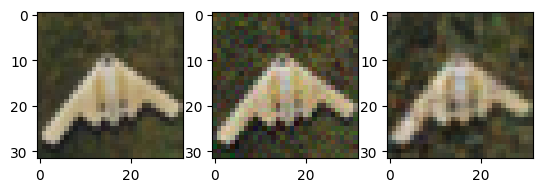

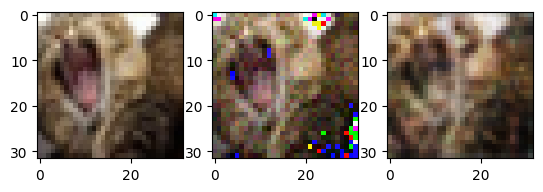

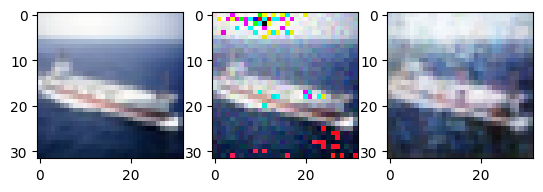

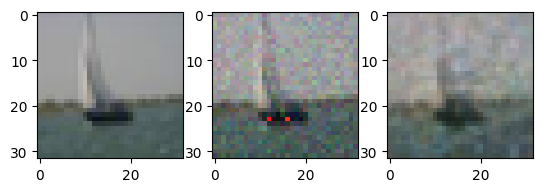

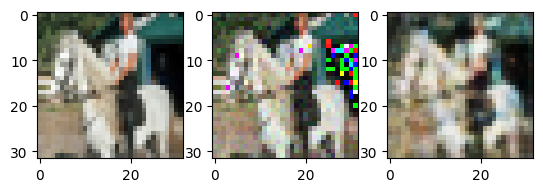

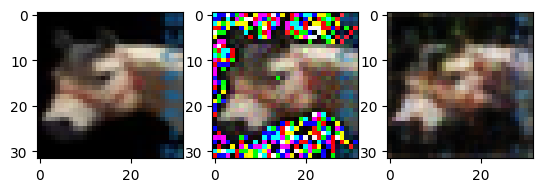

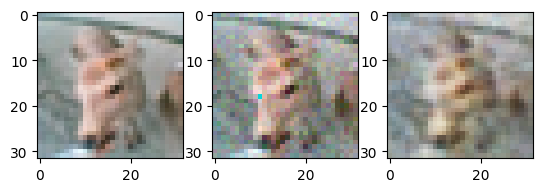

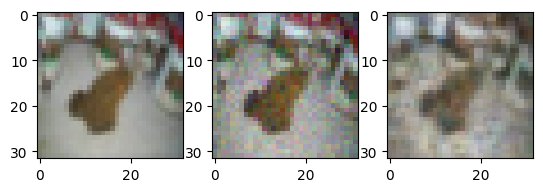

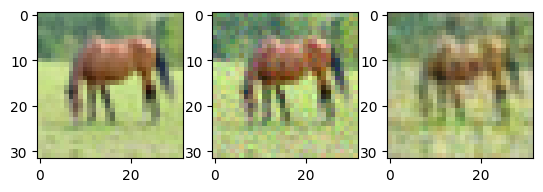

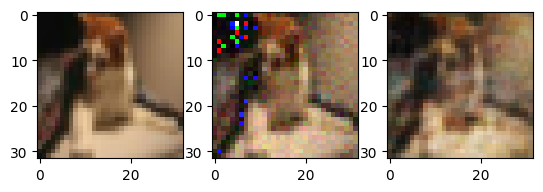

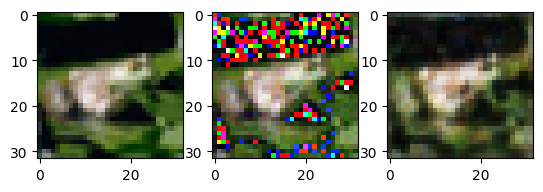

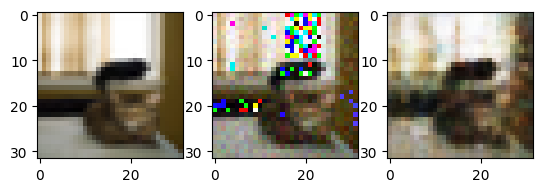

In [ ]:
model.load_state_dict(torch.load('model.pt'))
model.eval()
with torch.no_grad():
    for i, (img, targets) in enumerate(test_loader):
        if i > 0:
            break
        n_img = _add_noise(img, noise_factor, noise_mean, noise_var)
        img, n_img = img.to(device), n_img.to(device)
        r_img = model(n_img)
        loss = objective(r_img, img)
        for j in range(img.shape[0]):
            fig, axes = plt.subplots(nrows=1, ncols=3)
            axes[0].imshow(tensor_to_image(img[j].cpu()))
            axes[1].imshow(tensor_to_image(n_img[j].cpu()))
            axes[2].imshow(tensor_to_image(r_img[j].cpu()))